In [1]:
import os
import numpy as np
import muspy
from tqdm import tqdm
from matplotlib import pyplot as plt
import tensorflow as tf
import pickle

import config
import utils

config_string = "single_instruments_type"
ROOT_PATH = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

conf = config.Config(config_string, ROOT_PATH)

2023-04-24 09:05:19.332361: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 09:05:19.442503: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 09:05:19.475721: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-24 09:05:20.081830: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; 

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')


2023-04-24 09:05:22.146723: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30970 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:3b:00.0, compute capability: 7.0
2023-04-24 09:05:22.147314: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30970 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:86:00.0, compute capability: 7.0


In [2]:
with open(os.path.join(conf.dataset_paths["lmd_matched"], "lakh_matched_genre_vectors.pickle"), "rb") as f:
    genre_vectors = pickle.load(f)

dataset = utils.get_dataset("lmd_matched", conf)
len(dataset)

115190

## Study to choose final length of dataset

In [3]:
study_lengths = False

lengths = np.zeros(10000000)

discarded_samples = {
    0:0, # empty song
    1:0, # time_signatures not all acceptable
    2:0, # n_measures too big
    3:0, # too many notes
    4:0, # no genre
}

if study_lengths:

    for song, genre in (pbar := tqdm(zip(dataset, genre_vectors), total=len(dataset))):
        pbar.set_description("Long dataset matched")
        if type(genre) == type(None):
            discarded_samples[4] += 1

        else:
            converted_song = utils.transform_representation(song, conf)

            lengths[len(converted_song)] += 1

            if len(converted_song) <= 1:
                discarded_samples[converted_song[0]] += 1
else:
    lengths[10] = 1 # to avoid errors in the cells below


In [4]:
discarded_samples

{0: 0, 1: 0, 2: 0, 3: 0, 4: 0}

In [5]:
max = 0
for i in range(len(lengths)):
    if lengths[i]>0:
        max = i

In [6]:
lengths = lengths[:max+1]

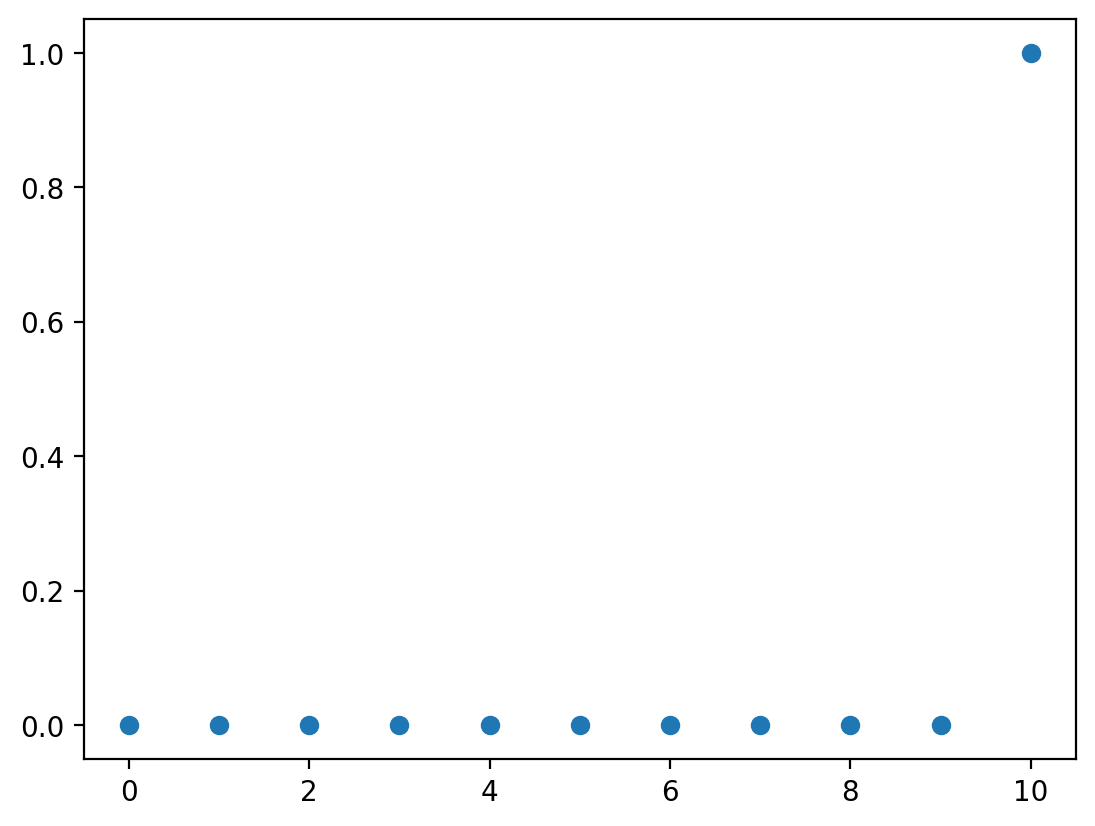

In [7]:
plt.scatter(np.arange(len(lengths)), lengths)

In [8]:
chosen_len=1024
chosen_len -= 2
print("Percentage of song kept if discarding every song longer than {}: {}".format(chosen_len, np.sum(lengths[:chosen_len])/np.sum(lengths)))
chosen_len=2048 
chosen_len -= 2
print("Percentage of song kept if discarding every song longer than {}: {}".format(chosen_len, np.sum(lengths[:chosen_len])/np.sum(lengths)))
chosen_len=2048 + 1024
chosen_len -= 2
print("Percentage of song kept if discarding every song longer than {}: {}".format(chosen_len, np.sum(lengths[:chosen_len])/np.sum(lengths)))
chosen_len=2048 + 2048
chosen_len -= 2
print("Percentage of song kept if discarding every song longer than {}: {}".format(chosen_len, np.sum(lengths[:chosen_len])/np.sum(lengths)))

Percentage of song kept if discarding every song longer than 1022: 1.0
Percentage of song kept if discarding every song longer than 2046: 1.0
Percentage of song kept if discarding every song longer than 3070: 1.0
Percentage of song kept if discarding every song longer than 4094: 1.0


In [10]:
weighed_lenghts = lengths.astype(np.int64)*np.arange(len(lengths))

In [11]:
chosen_len=1024
chosen_len -= 2
print("Percentage of dataset information by cutting every song to {} tokens: {}".format(chosen_len, (np.sum(weighed_lenghts[:chosen_len]) + np.sum(lengths[chosen_len:])*chosen_len) / np.sum(weighed_lenghts)))
chosen_len=2048
chosen_len -= 2
print("Percentage of dataset information by cutting every song to {} tokens: {}".format(chosen_len, (np.sum(weighed_lenghts[:chosen_len]) + np.sum(lengths[chosen_len:])*chosen_len) / np.sum(weighed_lenghts)))
chosen_len=2048 + 1024
chosen_len -= 2
print("Percentage of dataset information by cutting every song to {} tokens: {}".format(chosen_len, (np.sum(weighed_lenghts[:chosen_len]) + np.sum(lengths[chosen_len:])*chosen_len) / np.sum(weighed_lenghts)))
chosen_len=2048 + 2048
chosen_len -= 2
print("Percentage of dataset information by cutting every song to {} tokens: {}".format(chosen_len, (np.sum(weighed_lenghts[:chosen_len]) + np.sum(lengths[chosen_len:])*chosen_len) / np.sum(weighed_lenghts)))

Percentage of dataset information by cutting every song to 1022 tokens: 1.0
Percentage of dataset information by cutting every song to 2046 tokens: 1.0
Percentage of dataset information by cutting every song to 3070 tokens: 1.0
Percentage of dataset information by cutting every song to 4094 tokens: 1.0


In [12]:
a = [[1],
     [1, 2],
     [1, 2, 3],
     [1, 2, 3, 4], 
     [1, 2, 3, 4, 5]]

chosen_len = 5
# devono uscire lunghezza 4 alla fine
chosen_len-=2

for l in a:
    if len(l) >= chosen_len:
        print(l[:chosen_len]+[0])
    else:
        print(l+[0]*(chosen_len-len(l)+1))

[1, 0, 0, 0]
[1, 2, 0, 0]
[1, 2, 3, 0]
[1, 2, 3, 0]
[1, 2, 3, 0]


In [13]:
a = [1, 2, 3]
a[:10]

[1, 2, 3]

In [14]:
def create_tf_dataset(dataset, genre_vectors, chosen_len, cut_songs):

    chosen_len -= 2

    samples = []
    genres = []
    labels = {key:[] for key in conf.INPUT_RANGES.keys()}

    discarded_samples = {
        0:0, # empty song
        1:0, # time_signatures not all acceptable
        2:0, # n_measures too big
        3:0, # too many notes
        4:0, # no genre
    }

    for song, genre in (pbar := tqdm(zip(dataset, genre_vectors), total=len(dataset))):
        pbar.set_description("Long dataset matched")

        bool_accepted = False

        if type(genre) == type(None):
            discarded_samples[4] += 1

        else:
            converted_song = utils.transform_representation(song, conf)

            if len(converted_song) <= 1:
                discarded_samples[converted_song[0]] += 1

            else:

                if len(converted_song) >= chosen_len:
                    if cut_songs:
                        padding = tf.cast([[7]+[0]*10], dtype=np.uint8) # only add the final token to be sure that the song ends
                        bool_accepted = True
                    else:
                        discarded_samples[3] += 1
                    
                else:
                    padding = tf.cast(np.stack([[7]+[0]*10]*(chosen_len-len(converted_song)+1), axis=0), dtype=np.uint8)
                    bool_accepted = True

        
        if bool_accepted:
            sample = np.concatenate((
                    converted_song[:chosen_len], # also works for songs shorter than chosen_len
                    tf.identity(padding)
                ), dtype=np.uint8
            )

            samples.append(sample)
            genres.append(genre)

            for i, key in enumerate(labels.keys()):
                labels[key].append(sample[:,i])

    return tf.data.Dataset.from_tensor_slices(((samples, genres), labels)), discarded_samples

In [15]:
tf_dataset, discarded_samples = create_tf_dataset(dataset, genre_vectors, chosen_len=4096, cut_songs=True)
tf_dataset.save(conf.dataset_paths["lmd_matched_final_4096_cut"])

Long dataset matched: 100%|██████████| 115190/115190 [3:13:53<00:00,  9.90it/s]  


In [ ]:
tf_dataset, discarded_samples = create_tf_dataset(dataset, genre_vectors, chosen_len=2048, cut_songs=True)
tf_dataset.save(conf.dataset_paths["lmd_matched_final_2048_cut"])

Long dataset matched:  50%|████▉     | 57516/115190 [1:37:26<1:49:29,  8.78it/s]

In [20]:
tot_discarded = sum(discarded_samples.values())
print("Kept {}% of the songs".format(((len(dataset)-tot_discarded))/len(dataset)*100))
print("Of the discarded: ")
print("- {:.2f}% were empty".format(discarded_samples[0]/tot_discarded*100))
print("- {:.2f}% contained not accepted time signatures".format(discarded_samples[1]/tot_discarded*100))
print("- {:.2f}% had too many measures".format(discarded_samples[2]/tot_discarded*100))
print("- {:.2f}% had too many events/notes".format(discarded_samples[3]/tot_discarded*100))
print("- {:.2f}% had no accepted genre".format(discarded_samples[4]/tot_discarded*100))

Kept 60.33162600920219% of the songs
Of the discarded: 
- 0.00% were empty
- 0.08% contained not accepted time signatures
- 1.28% had too many measures
- 0.00% had too many events/notes
- 98.64% had no accepted genre
